In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import joblib

In [ ]:
# Load scaled data

X_scaled = np.load("../data/processed/X_scaled.npy")

In [ ]:
# Load scaler

scaler = joblib.load("../models/scaler.pkl")

In [ ]:
# Convert to tensor

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

In [6]:
# Create Dataset & DataLoader

dataset = TensorDataset(X_tensor, X_tensor)

dataloader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True
)

In [7]:
# Define the Autoencoder Model

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=8):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [8]:
# Initialize Model, Loss & Optimizer

input_dim = X_tensor.shape[1]
latent_dim = 8

model = Autoencoder(input_dim, latent_dim)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [9]:
# Training Loop

epochs = 100
losses = []

for epoch in range(epochs):
    epoch_loss = 0.0

    for batch_x, _ in dataloader:
        optimizer.zero_grad()

        recon = model(batch_x)
        loss = criterion(recon, batch_x)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}")

Epoch [10/100] - Loss: 0.1058
Epoch [20/100] - Loss: 0.0691
Epoch [30/100] - Loss: 0.0594
Epoch [40/100] - Loss: 0.0543
Epoch [50/100] - Loss: 0.0512
Epoch [60/100] - Loss: 0.0487
Epoch [70/100] - Loss: 0.0465
Epoch [80/100] - Loss: 0.0448
Epoch [90/100] - Loss: 0.0441
Epoch [100/100] - Loss: 0.0420


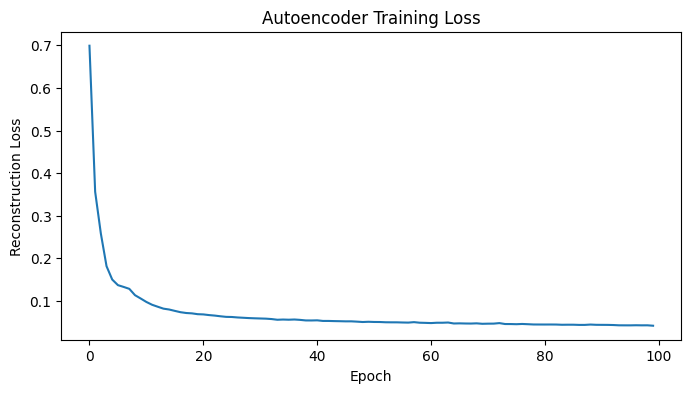

In [10]:
# Plot Training Loss

plt.figure(figsize=(8, 4))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss")
plt.title("Autoencoder Training Loss")
plt.show()

In [11]:
# Extract Fighter Embeddings

with torch.no_grad():
    embeddings = model.encoder(X_tensor).numpy()

embeddings.shape

(4451, 8)

In [12]:
# Save Model & Embeddings

torch.save(model.state_dict(), "../models/autoencoder.pth")

np.save("../data/processed/fighter_embeddings.npy", embeddings)